## Regresión

En esta lección, vas a aprender como combinar varias técnicas de ingeniería de variables que cubrimos a lo largo de este curso y cómo  aplicarlas en un problema de regresión. Esto te dará una idea de un flujo de trabajo de principio a fin para construir un modelo de aprendizaje de máquina en problemas de regresión.

Verás como:
- construir un modelo lasso
- usar feature-engine para los diferentes pasos de ingeniería de variables
- crear un flujo completo para la ingeniería y la predicción  usando el 'Pipeline' de Scikit-learn 

===================================================================================================

## En este demo:

Usaremos los datos del House Prices. Revisa la lección de **Datos** de la Sección 1 del curso, en donde encontrarás las instrucciones de como descargar los datos.

## Datos House Prices 

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para el modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# para la ingeniería de variables
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

pd.pandas.set_option('display.max_columns', None)

### Cargar los datos 

In [2]:
# cargar los datos 
data = pd.read_csv('../houseprice.csv')

print(data.shape)

data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Tipos de variables (sección 2)

Veamos que tipos de variables tenemos en los datos

In [3]:
# inspeccionemos los tipos de variables usando pandas

data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

Hay una combinación de variables categóricas y numéricas. Las variables numéricas son las de tipo 
**int** y **float** y las categóricas aquellas de tipo **object**.

In [4]:
# tenemos una variable Id, que NO se debe usar en la predicción:

print('Número único de Ids: ', len(data.Id.unique()))
print('Número de Casas en los datos: ', len(data))

Número único de Ids:  1460
Número de Casas en los datos:  1460


Los Ids son identificadores únicos por cada una de las casas. Por lo tanto no es una variable que podamos usar.

#### Encontremos las variables categóricas

In [5]:
# encontrar las variables categóricas
categorical = [var for var in data.columns if data[var].dtype=='O']

print('Hay {} variables categóricas'.format(len(categorical)))

Hay 43 variables categóricas


In [6]:
data[categorical].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


####  Variables fecha

Hay unas variables con información de sobre fechas en los datos. Estas indican el año en el cual algo en particular sucedió. No es recomendable usar estas variables directamente para el modelamiento, sugerimos transformarlas para capturar algo de la información temporal. 

Primero exploremos las variables:


In [7]:
# lista de las variables numéricas 
numerical = [var for var in data.columns if data[var].dtype!='O']

# lista de variables que tienen información de años
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [8]:
data[year_vars].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


Podemos ver que estas variables corresponden a los años en los cuales las casas fueron ya sea construidas, remodeladas, cuando un garage se construyó, ó cuando la casa se vendió. Sería mejor capturar el tiempo transcurrido entre el año en que la casa fué construída y luego vendida por ejemplo. Vamos a calcular esto en la sección de ingeniería más adelante en el notebook. 

Tenemos otra variable con fechas: MoSold, que indica cual fué el mes en el cual la casa se vendió. Inspeccionemos si el precio de la casa varía con el mes del año en la cual se vendió:

Text(0, 0.5, 'Precio mediano')

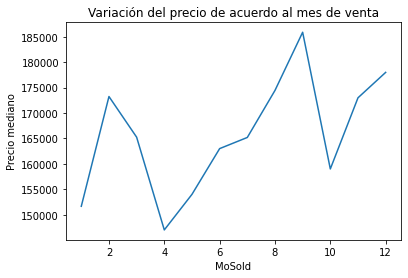

In [9]:
# gráfica de la mediana del precio de las casas
# de acuerdo al mes de venta

data.groupby('MoSold')['SalePrice'].median().plot()
plt.title('Variación del precio de acuerdo al mes de venta')
plt.ylabel('Precio mediano')

El precio parece variar dependiendo del mes en el cual la casa se vende.

#### Variables discretas

Para identificar las variables discretas, las seleccionaremos de las variables numéricas, y las definimos como aquellas que contienen un número finito y pequeño de valores.

Exploremos las variables:

In [10]:
# visualicemos los valores de las variables discretas
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20 and var not in year_vars:
        print(var, ' valores: ', data[var].unique())
        discrete.append(var)
print()
print('Hay {} variables discretas '.format(len(discrete)))

MSSubClass  valores:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  valores:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  valores:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  valores:  [1 0 2 3]
BsmtHalfBath  valores:  [0 1 2]
FullBath  valores:  [2 1 3 0]
HalfBath  valores:  [1 0 2]
BedroomAbvGr  valores:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  valores:  [1 2 3 0]
TotRmsAbvGrd  valores:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  valores:  [0 1 2 3]
GarageCars  valores:  [2 3 1 0 4]
PoolArea  valores:  [  0 512 648 576 555 480 519 738]
MoSold  valores:  [ 2  5  9 12 10  8 11  4  1  7  3  6]

Hay 14 variables discretas 


#### Variables continua

In [11]:
# busquemos las variables continuas 
# recuerda obviar las variable Id y la variable target SalePrice
# las cuales son ambas numéricas

numerical = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('Hay {} variables continuas y numéricas'.format(len(numerical)))

Hay 18 variables continuas y numéricas


Perfecto!! Ahora vamos a inspeccionar las variables e identificar los diferentes tipos de variables que tiene el conjunto de datos. Prosigamos a entender el tipo de problemas que estas variables tienen.

### Tipos de problemas con las variables (sección 3)

#### Valores Faltantes

In [12]:
# variables con NA y el porcentaje de NA

for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

LotFrontage 0.1773972602739726
Alley 0.9376712328767123
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtExposure 0.026027397260273973
BsmtFinType1 0.025342465753424658
BsmtFinType2 0.026027397260273973
Electrical 0.0006849315068493151
FireplaceQu 0.4726027397260274
GarageType 0.05547945205479452
GarageYrBlt 0.05547945205479452
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
PoolQC 0.9952054794520548
Fence 0.8075342465753425
MiscFeature 0.963013698630137


#### Valores extremos y distribuciones

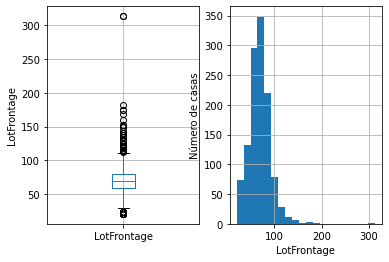

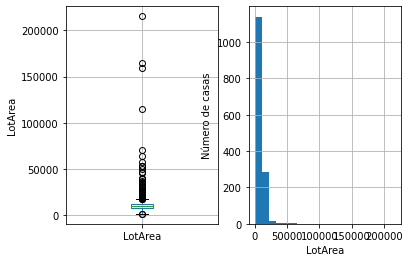

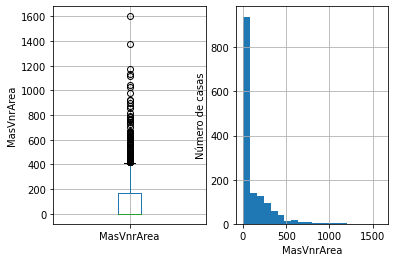

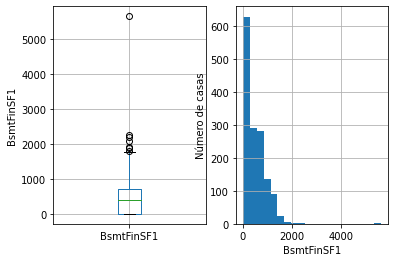

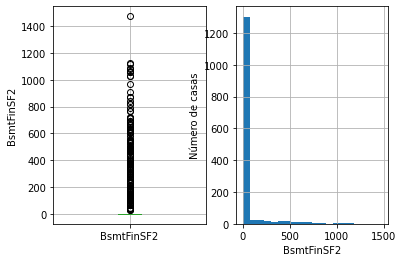

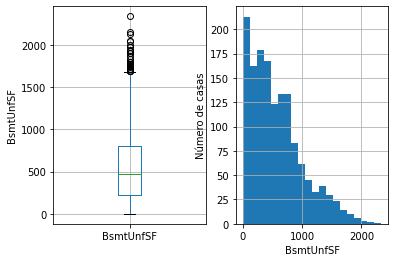

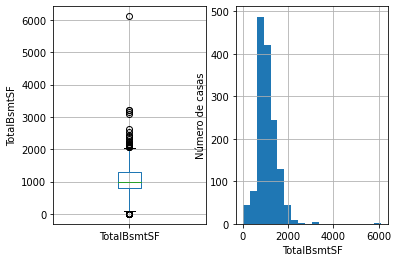

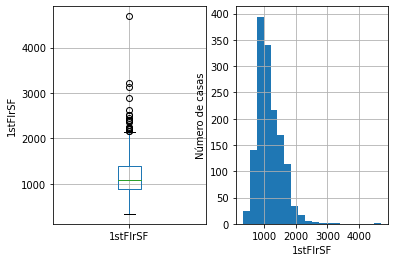

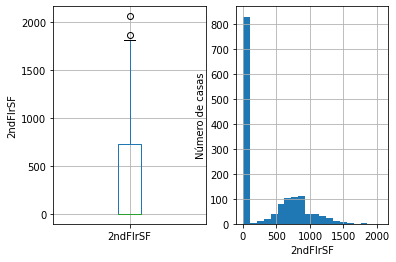

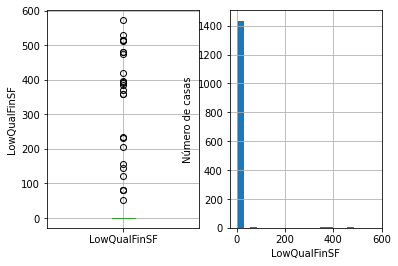

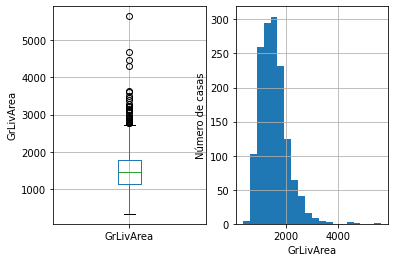

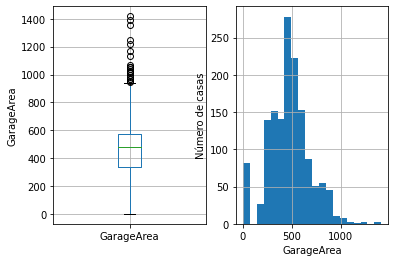

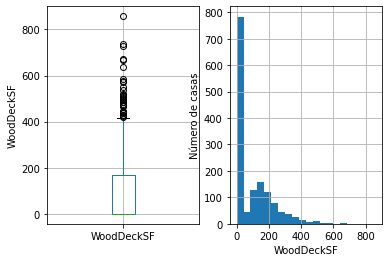

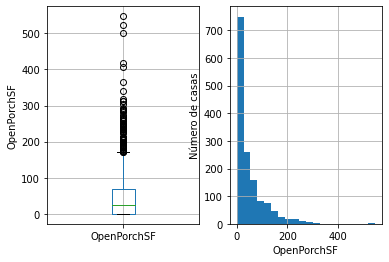

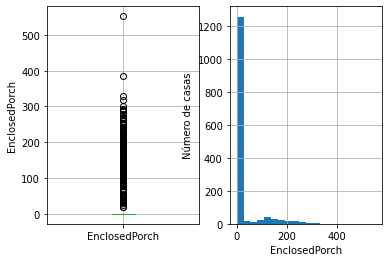

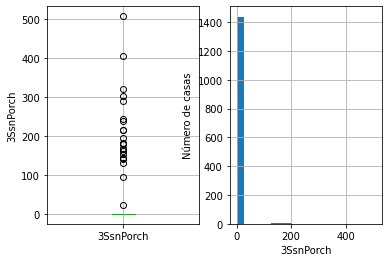

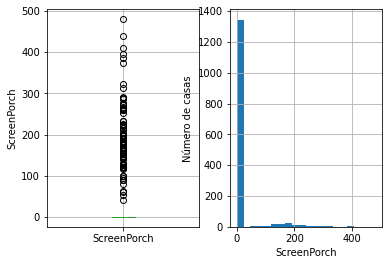

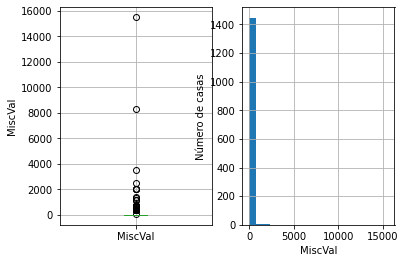

In [13]:
# gráficos de caja para visualizar los valores extremos
# en las variables continuas e histogramas 
# para tener una idea del tipo de distribución

for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Número de casas')
    fig.set_xlabel(var)

    plt.show()

La mayoría de las variables continuas parecen tener valores extremos. Además, muchas de las variables no están normalmente distribuídas. Ya que estamos planeando constuir un modelo de regresión lineal, es necesaria pre-procesar las variables para mejorar el desempeño del modelo. 

Para la ingeniería de estos dos aspectos, vamos a discretizar las variables, y continuaremos con la codificación de los intervalos siguiendo la media del target, como lo vimos en la lección **Discretización más codificacíon** en la sección 8.

#### Outliers en las variables discretas

Ahora, identifiquemos los valores extremos en las variables discretas. Definiremos como outliers aquellos valores que estén presentes en menos del 5 % de las casas. Esto es exactamente lo mismo que encontrar las etiquetas raras en las variables categóricas. **Las variables discretas pueden ser pre-procesadas como si fueran categóricas**!

<ipython-input-14-fbb75762c604>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (data.groupby(var)[var].count() / np.float(len(data))).plot.bar()


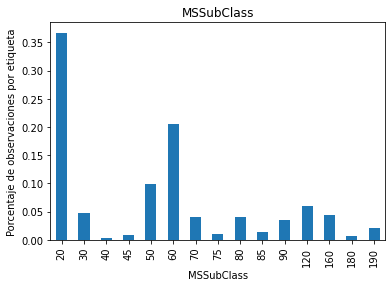

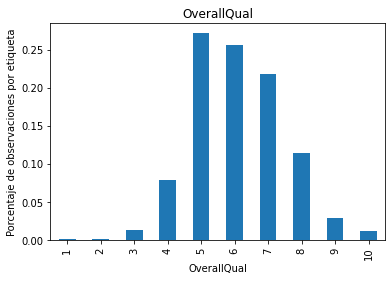

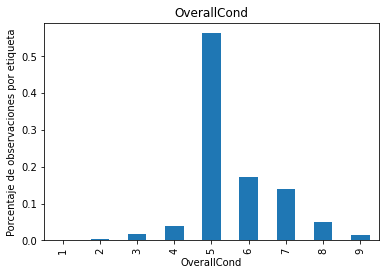

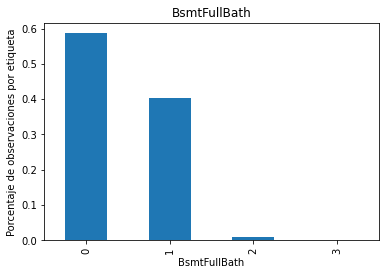

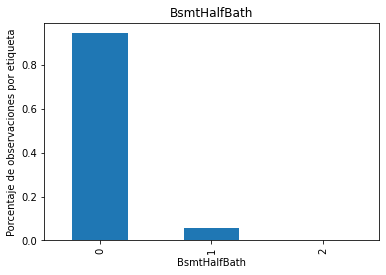

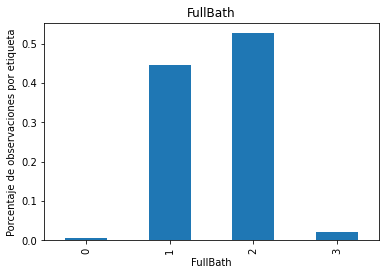

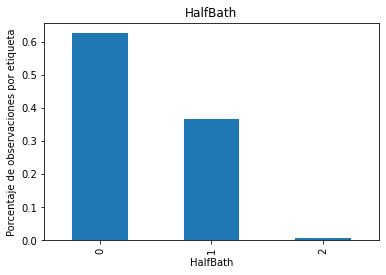

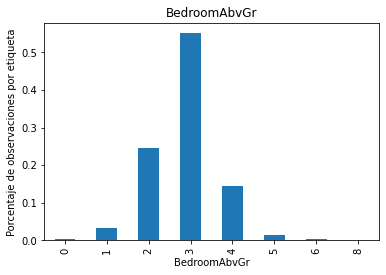

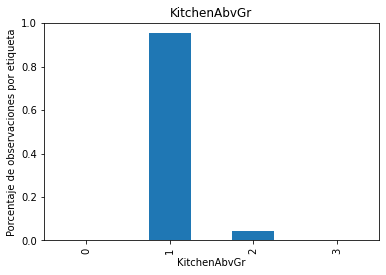

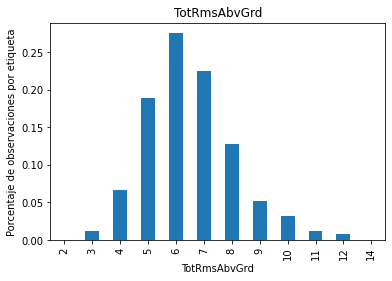

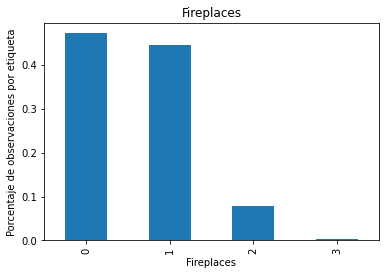

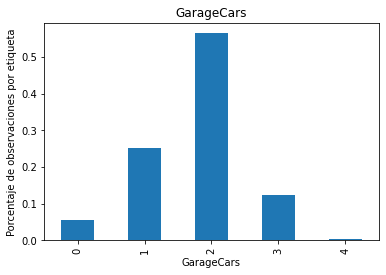

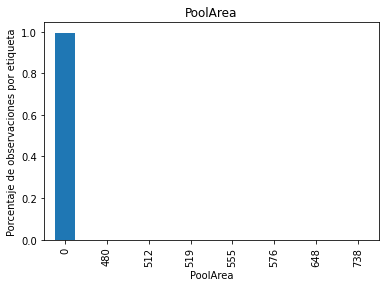

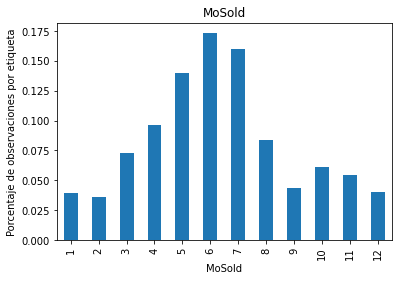

In [14]:
# Outliers en las variables discretas

for var in discrete:
    (data.groupby(var)[var].count() / np.float(len(data))).plot.bar()
    plt.ylabel('Porcentaje de observaciones por etiqueta')
    plt.title(var)
    plt.show()

La mayoría de las variables discretas tienen valores que están compartidos por una pequeña proporción de las casas en los datos.

### Monoticidad entre las variables discretas y los valores del target

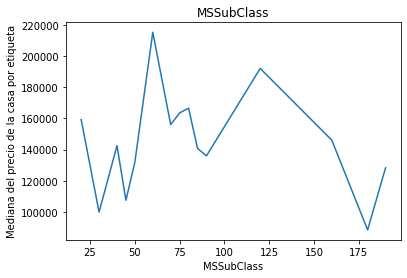

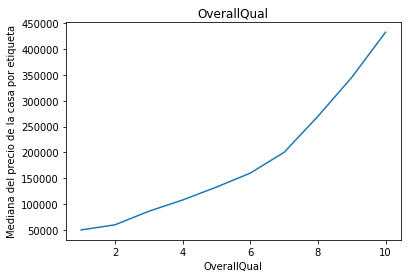

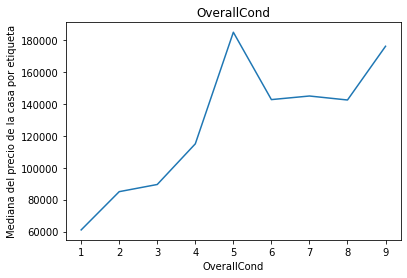

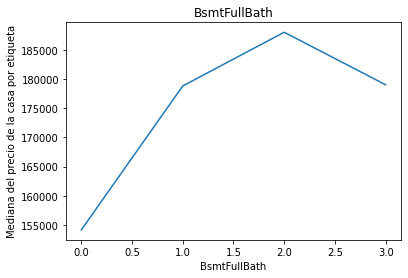

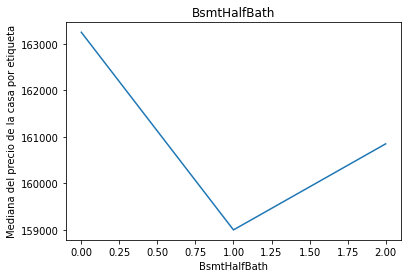

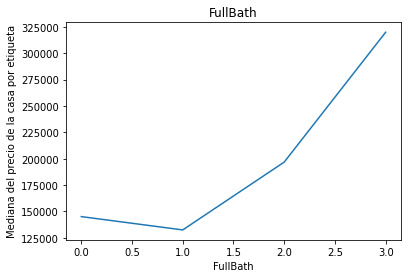

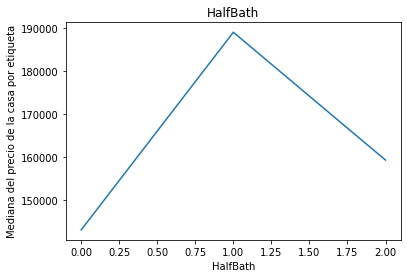

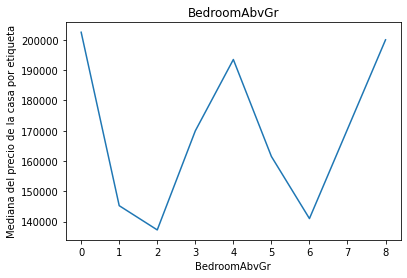

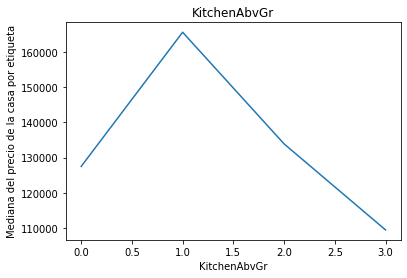

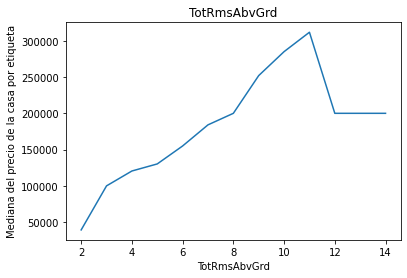

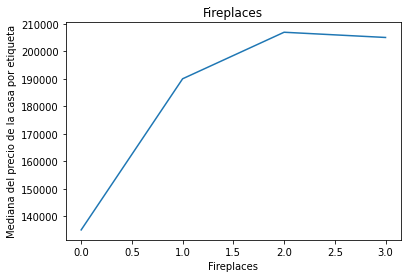

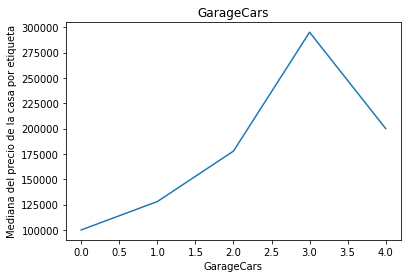

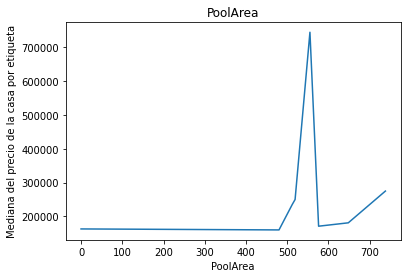

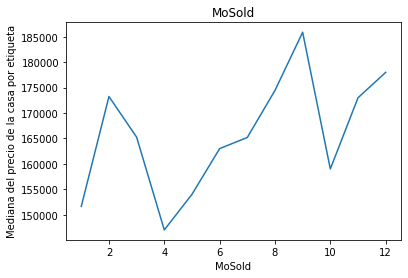

In [15]:
# grafiquemos la mediana del precio de venta por el valor 
# de la variable discreta

for var in discrete:
    data.groupby(var)['SalePrice'].median().plot()
    plt.ylabel('Mediana del precio de la casa por etiqueta')
    plt.title(var)
    plt.show()

Algunas de las variables discretas muestran algo de relación monotónica con el target y otras no.

#### Número de etiquetas: cardinalidad

Ahora examinemos la cardinalidad de las variables categóricas. Esto es, el número de las diferentes etiquetas.

Text(0, 0.5, 'Número de diferentes categorías ')

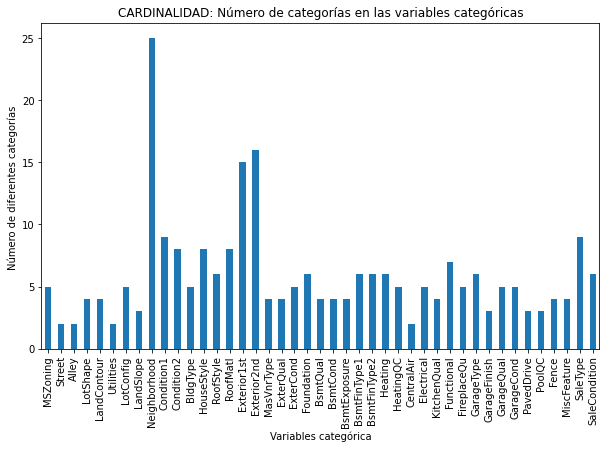

In [16]:
# graficar el número de categorías por
# variable categórica

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALIDAD: Número de categorías en las variables categóricas')
plt.xlabel('Variables categórica')
plt.ylabel('Número de diferentes categorías ')

Muchas de las variables, tienen solo unas pocas etiquetas. Por lo tanto no tenemos q preocuparnos por manipular la alta cardinaldad de las variables. Estas son buenas noticias!

Muy probablemente, estas variables si tendrán etiquetas raras. Por que no vas y graficas la frecuencia de las categorías de cada variable categórica? Aprendimos como hacer esto en la sección 3 del curso.

### Separemos los datos en los sets de entrenamiento y prueba 

In [17]:
# Separemos los datos en los sets de entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Ahora proseguiremos con la ingenería de las variables en los datos. La parte más importante de este curso.**

### Variables temporales  (Sección 12)

Primero, creemos las variables temporales que discutimos al principio del notebook

In [18]:
# función para calcular el tiempo transcurrido

def elapsed_years(df, var):
    # captura la diferencia entre el año de construcción y 
    # el año de venta
    
    df[var] = df['YrSold'] - df[var]
    return df

In [19]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [20]:
X_train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
930,2,2,2.0
656,49,2,49.0
45,5,5,5.0
1348,9,9,9.0
55,44,44,44.0


En lugar del "año", ahora vamos a calcular **los años que han transcurrido** desde que la casa fué construida o remodelada y cuando la casa fué vendida. Luego, eliminaremos la variable YrSold de los datos, porque ya habíamos extraído su valor 

In [21]:
# eliminar variable YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [22]:
# capturar los nombres de las columnas para usar más adelante
# en el notebook 
final_columns = X_train.columns

### Imputación de los datos faltantes  (sección 4)
#### Variables continuas

In [23]:
# imprimir las variables con datos faltantes

# recuerda que ahora que creamos esas variables
# temporales, vamos a proseguir con la ingeniería
# las variables numéricas y continuas:

# eliminar la variable YrSold de la lista de variables
# porque no está más en los datos
year_vars.remove('YrSold')

# examinemos el porcentaje de los valores faltantes
for col in numerical+year_vars:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.17732115677321156
MasVnrArea 0.0045662100456621
GarageYrBlt 0.0563165905631659


La técnica de imputación que vamos a usar es: **la variable adicional con NA + imputación por la mediana**

In [24]:
# imprimir las variables con datos faltantes

for col in categorical:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

Alley 0.9383561643835616
MasVnrType 0.0045662100456621
BsmtQual 0.0243531202435312
BsmtCond 0.0243531202435312
BsmtExposure 0.02511415525114155
BsmtFinType1 0.0243531202435312
BsmtFinType2 0.02511415525114155
Electrical 0.00076103500761035
FireplaceQu 0.4726027397260274
GarageType 0.0563165905631659
GarageFinish 0.0563165905631659
GarageQual 0.0563165905631659
GarageCond 0.0563165905631659
PoolQC 0.9954337899543378
Fence 0.8143074581430746
MiscFeature 0.9611872146118722


La técnica a usar: **Añadir la etiqueta 'missing' en las variables categóricas**

## Juntando todos los pasos

In [25]:
# Manipularemos las variables discretas 
# como si fueran categóricas. 
# Vamos a usar Feature-engine
# así que necesitamos cambiar el tipo 
# de variable a tipo object 

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [26]:
house_pipe = Pipeline([

    # imputación de datos faltantes - sección 4
    ('missing_ind', mdi.AddMissingIndicator(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_num', mdi.MeanMedianImputer(
        imputation_method='median',
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalImputer(
        variables=categorical)),

    # codificación variables categóricas - sección 6
    ('rare_label_enc', ce.RareLabelEncoder(
        tol=0.05, n_categories=4, variables=categorical+discrete)),
    
    ('categorical_enc', ce.OrdinalEncoder(
        encoding_method='ordered', variables=categorical+discrete)),

    # discretización + codificación - sección 8
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=numerical)),
    
    ('encoding', ce.OrdinalEncoder(
        encoding_method='ordered', variables=numerical)),

    # escalamiento de las variables - sección 10
    ('scaler', StandardScaler()),
    
    # regresión
    ('lasso', Lasso(random_state=0))
])

In [27]:
# ajustemos el pipeline o flujo de trabajo
house_pipe.fit(X_train, y_train)

# generemos las predicciones
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable LotShape is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categ

In [28]:
# valores de las predicciones
X_train_preds

array([249534.31487481, 157315.37366933, 297790.27318893, ...,
       107443.77213912, 208553.37774897, 228141.1074486 ])

In [29]:
# revisa el desempeño del modelo:

print('entrenamiento mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('entrenamiento rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('entrenamiento r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('prueba mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('prueba rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('prueba r2: {}'.format(r2_score(y_test, X_test_preds)))

entrenamiento mse: 1041957140.0424039
entrenamiento rmse: 32279.36089891502
entrenamiento r2: 0.8331221659008516

prueba mse: 1980828766.6985211
prueba rmse: 44506.502521525115
prueba r2: 0.7117585075229178


Text(0, 0.5, 'Predicción precio venta')

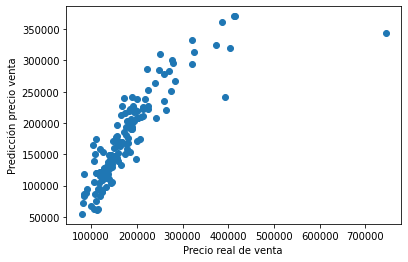

In [30]:
# grafica predicciones vs valor real 

plt.scatter(y_test,X_test_preds)
plt.xlabel('Precio real de venta ')
plt.ylabel('Predicción precio venta')

<AxesSubplot:>

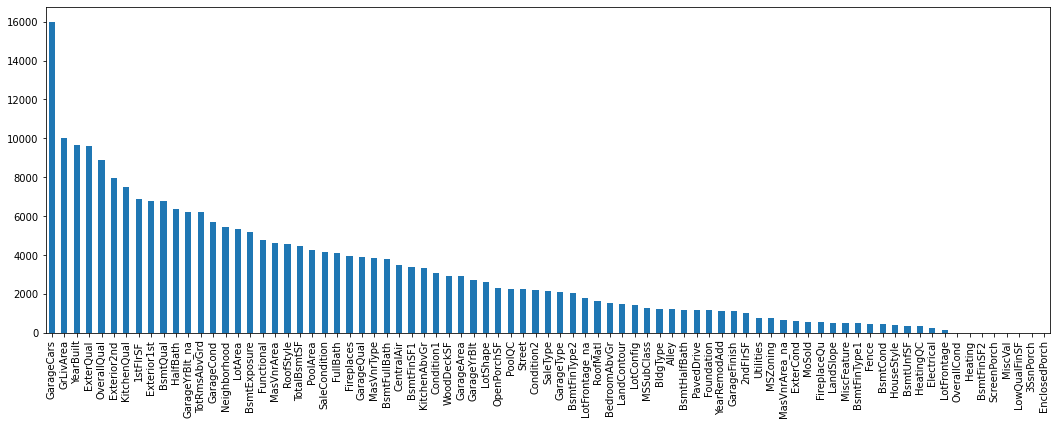

In [31]:
# exploremos la importancia de las variables
# la importancia es data por el valor absoluto
# de los coeficientes asingados por el método Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))